In [1]:
import numpy as np
import torch


import json
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch import nn

from statistics import mean

In [2]:
import utils_generic as generic
import rrnn_modelo as rrnn
import model_confs as confs
import singletask_dep as st

import train

from gensim.models import KeyedVectors

c:\Users\kuina\anaconda3\envs\tfg\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

word2vec_path = r"C:\Users\kuina\gensim-data\word2vec-google-news-300\word2vec-google-news-300.gz"
word2vec_model =  KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

encoding_type = 'brk'

# Datos ConvAI2

In [4]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [5]:
convai_train = data['train']
convai_val = data['validation']


vocabulary = set(generic.create_word_to_index(convai_train).keys()) & set(word2vec_model.key_to_index.keys())
word_to_index = {}
emb_weights = []
for new_id, word in zip(range(len(vocabulary)),vocabulary):
    word_to_index[word] = new_id
    emb_weights.append(word2vec_model[word])

emb_weights = np.array(emb_weights)



In [6]:
vocab_dep = st.Vocabulary(data['train'],encoding_type)
convai_train_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_train,['about','to','as'],vocab_dep,word_to_index) 
convai_val_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_val,['about','to','as'],vocab_dep,word_to_index) 

In [7]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = rrnn.DatasetSingleTaskRRNN(convai_train_token,task,eval=False,deps=True)

In [8]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = rrnn.DatasetSingleTaskRRNN(convai_val_token,task,eval=False,deps=True)

# Datos md_gender

In [9]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [10]:
md_tokenized = generic.tokenize_dataset_with_dependencies_rrnn(md_data,['about','to','as'],vocab_dep,word_to_index) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = rrnn.DatasetSingleTaskRRNN(md_tokenized,task,eval=True,deps=True)

# Creación dataloaders

In [11]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [12]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [13]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=rrnn.collate_fn_dep)

# Prueba hiperparámetros 1

In [14]:
emb_dim = 20
vocab_size = len(word_to_index)
lstm_hidden_dim = 128

## ABOUT

In [15]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6887233152414448 	 Validation loss: 0.6868543089446375 	 
  1%|          | 574/57400 [00:05<08:19, 113.71it/s]
Epoch 2 	 Training loss: 0.6840165356102721 	 Validation loss: 0.6847577337491311 	 
  2%|▏         | 1148/57400 [00:11<08:10, 114.68it/s]
Epoch 3 	 Training loss: 0.6821512243473571 	 Validation loss: 0.6840534715329186 	 
  3%|▎         | 1722/57400 [00:16<08:08, 113.89it/s]
Epoch 4 	 Training loss: 0.6814172087230749 	 Validation loss: 0.6840677645246861 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:22<08:01, 114.41it/s]
Epoch 5 	 Training loss: 0.6812263068837155 	 Validation loss: 0.6838572378885948 	 
  5%|▌         | 2870/57400 [00:27<07:57, 114.22it/s]
Epoch 6 	 Training loss: 0.6811212883801411 	 Validation loss: 0.6838752102043669 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [00:32<08:02, 111.71it/s]
Epoch 7 	 Training loss: 0.6810086341477437 	 Validation loss: 0.6838466979689517 	 
  7%|▋         | 4018/57

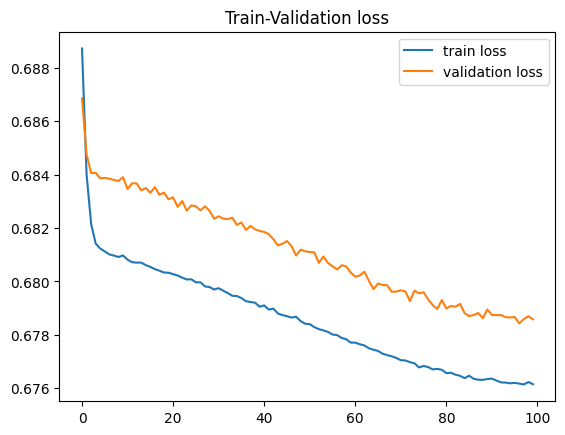

In [16]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_about_w2v_1'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [17]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.4897959183673469, 'precision': 0.4897959183673469, 'f1': 0.4897959183673469, 'accuracy': 0.4897959183673469}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5189393939393939, 'precision': 0.5189393939393939, 'f1': 0.5189393939393939, 'accuracy': 0.5189393939393939}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.516297262059974, 'precision': 0.516297262059974, 'f1': 0.516297262059974, 'accuracy': 0.516297262059974}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0} 



  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6935802168547068 	 Validation loss: 0.6898757249622022 	 
  1%|          | 574/57400 [00:05<08:31, 111.02it/s]
Epoch 2 	 Training loss: 0.6862430751116019 	 Validation loss: 0.6857619871527462 	 
  2%|▏         | 1148/57400 [00:11<08:34, 109.28it/s]
Epoch 3 	 Training loss: 0.6829980922285273 	 Validation loss: 0.6843782299655979 	 
  3%|▎         | 1722/57400 [00:16<08:18, 111.79it/s]
Epoch 4 	 Training loss: 0.6817550882437503 	 Validation loss: 0.684088684744754 	 
  4%|▍         | 2296/57400 [00:22<08:19, 110.24it/s]
Epoch 5 	 Training loss: 0.6814598401664441 	 Validation loss: 0.6839377122410273 	 
  5%|▌         | 2870/57400 [00:27<08:04, 112.58it/s]
Epoch 6 	 Training loss: 0.6811511182203526 	 Validation loss: 0.6840814655109987 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [00:33<08:02, 111.82it/s]
Epoch 7 	 Training loss: 0.6812521405128652 	 Validation loss: 0.6837736226744571 	 
  7%|▋         | 4018/57400 [00:38<08:00, 110.99it/s]


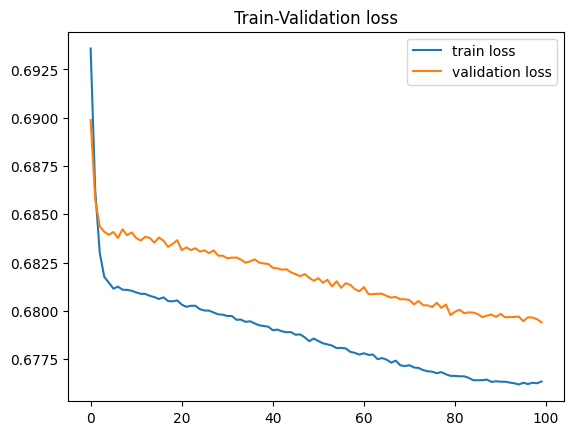

In [18]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_about_w2v_2'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [19]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.49107142857142855, 'precision': 0.49107142857142855, 'f1': 0.49107142857142855, 'accuracy': 0.49107142857142855}
MALE {'recall': 0.9947916666666666, 'precision': 0.9947916666666666, 'f1': 0.9947916666666666, 'accuracy': 0.9947916666666666}
FEMALE {'recall': 0.0075, 'precision': 0.0075, 'f1': 0.0075, 'accuracy': 0.0075} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5202020202020202, 'precision': 0.5202020202020202, 'f1': 0.5202020202020202, 'accuracy': 0.5202020202020202}
MALE {'recall': 0.9927007299270073, 'precision': 0.9927007299270073, 'f1': 0.9927007299270073, 'accuracy': 0.9927007299270073}
FEMALE {'recall': 0.010498687664041995, 'precision': 0.010498687664041995, 'f1': 0.010498687664041995, 'accuracy': 0.010498687664041995} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5202086049543677, 'precision': 0.5202086049543677, 'f1': 0.5202086049543677, 'accuracy': 0.5202086049543677}
MALE

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6904071574634791 	 Validation loss: 0.6880178108053693 	 
  1%|          | 574/57400 [00:05<08:20, 113.52it/s]
Epoch 2 	 Training loss: 0.6849353824343 	 Validation loss: 0.6852316997819028 	 
  2%|▏         | 1148/57400 [00:11<08:20, 112.34it/s]
Epoch 3 	 Training loss: 0.6827128269946534 	 Validation loss: 0.6844816228090707 	 
  3%|▎         | 1722/57400 [00:16<08:12, 113.09it/s]
Epoch 4 	 Training loss: 0.6819163534907099 	 Validation loss: 0.6842744128178742 	 
  4%|▍         | 2296/57400 [00:22<08:09, 112.65it/s]
Epoch 5 	 Training loss: 0.681644885693693 	 Validation loss: 0.684296839318033 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [00:27<08:10, 111.16it/s]
Epoch 6 	 Training loss: 0.6814648701131136 	 Validation loss: 0.6841849674612789 	 
  6%|▌         | 3444/57400 [00:33<08:13, 109.43it/s]
Epoch 7 	 Training loss: 0.6812947122477488 	 Validation loss: 0.6842454641552295 	 

1 epoch without improvement
  7%|▋         | 4018/57400 [

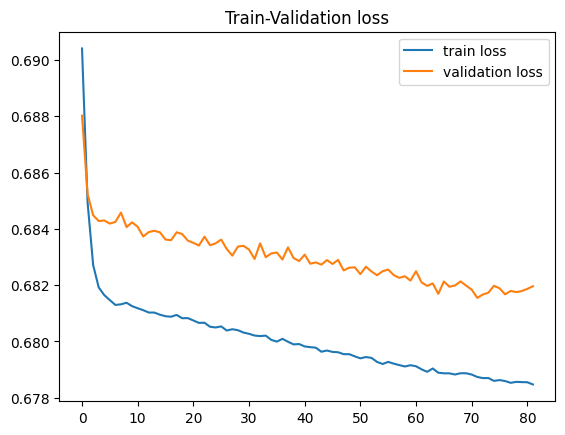

In [20]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_about_w2v_3'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [21]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.4897959183673469, 'precision': 0.4897959183673469, 'f1': 0.4897959183673469, 'accuracy': 0.4897959183673469}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5189393939393939, 'precision': 0.5189393939393939, 'f1': 0.5189393939393939, 'accuracy': 0.5189393939393939}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.516297262059974, 'precision': 0.516297262059974, 'f1': 0.516297262059974, 'accuracy': 0.516297262059974}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0} 



In [22]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.49022108843537415, 'precision': 0.49022108843537415, 'f1': 0.49022108843537415, 'accuracy': 0.49022108843537415}
Métricas etiqueta male: {'recall': 0.9982638888888888, 'precision': 0.9982638888888888, 'f1': 0.9982638888888888, 'accuracy': 0.9982638888888888}
Métricas etiqueta female:  {'recall': 0.0025, 'precision': 0.0025, 'f1': 0.0025, 'accuracy': 0.0025}

 to
Resultado global: {'recall': 0.5193602693602694, 'precision': 0.5193602693602694, 'f1': 0.5193602693602694, 'accuracy': 0.5193602693602694}
Métricas etiqueta male: {'recall': 0.9975669099756691, 'precision': 0.9975669099756691, 'f1': 0.9975669099756691, 'accuracy': 0.9975669099756691}
Métricas etiqueta female:  {'recall': 0.003499562554680665, 'precision': 0.003499562554680665, 'f1': 0.003499562554680665, 'accuracy': 0.003499562554680665}

 as
Resultado global: {'recall': 0.5176010430247718, 'precision': 0.5176010430247718, 'f1': 0.5176010430247718, 'accuracy': 0.51760

## TO

In [23]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6938481416021075 	 Validation loss: 0.6914508201308169 	 
  1%|          | 574/57400 [00:06<09:35, 98.81it/s]
Epoch 2 	 Training loss: 0.6933349162236323 	 Validation loss: 0.6922628616882582 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:12<09:30, 98.56it/s]
Epoch 3 	 Training loss: 0.6932427887301827 	 Validation loss: 0.6926429726309695 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:18<09:10, 101.09it/s]
Epoch 4 	 Training loss: 0.6932223799544345 	 Validation loss: 0.6929446034512278 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:24<09:11, 100.00it/s]
Epoch 5 	 Training loss: 0.6931403515023221 	 Validation loss: 0.6931368951070107 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [00:30<09:02, 100.57it/s]
Epoch 6 	 Training loss: 0.6932009681799686 	 Validation loss: 0.6931587508169271 	 

5 epoch without improvement
  6%|▌         | 3444/57400 [00:37<08:52, 101.34it/s]
Epoch 7 	 Training loss:

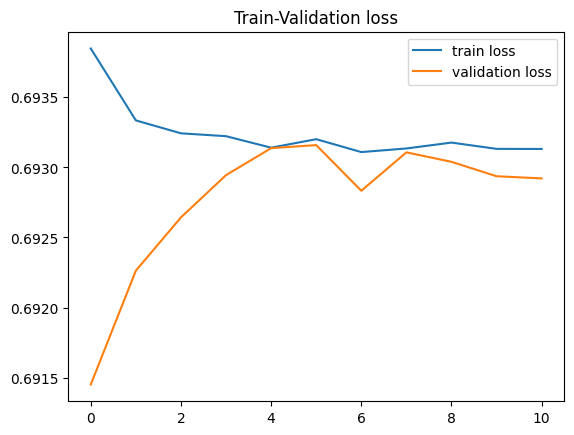

In [24]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_to_w2v_1'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [25]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5102040816326531, 'precision': 0.5102040816326531, 'f1': 0.5102040816326531, 'accuracy': 0.5102040816326531}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4810606060606061, 'precision': 0.4810606060606061, 'f1': 0.4810606060606061, 'accuracy': 0.4810606060606061}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.48370273794002605, 'precision': 0.48370273794002605, 'f1': 0.48370273794002605, 'accuracy': 0.48370273794002605}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0} 



  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6932684069934207 	 Validation loss: 0.6932198496188148 	 
  1%|          | 574/57400 [00:06<09:23, 100.93it/s]
Epoch 2 	 Training loss: 0.6931748496115415 	 Validation loss: 0.6932493731126947 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:12<09:18, 100.70it/s]
Epoch 3 	 Training loss: 0.6931573594904112 	 Validation loss: 0.6930838045427354 	 
  3%|▎         | 1722/57400 [00:18<09:14, 100.43it/s]
Epoch 4 	 Training loss: 0.693056695656494 	 Validation loss: 0.693077569290743 	 
  4%|▍         | 2296/57400 [00:24<09:11, 99.97it/s]
Epoch 5 	 Training loss: 0.6931313705153581 	 Validation loss: 0.6930204781435304 	 
  5%|▌         | 2870/57400 [00:30<09:05, 99.97it/s]
Epoch 6 	 Training loss: 0.6931403428835321 	 Validation loss: 0.6928975420483088 	 
  6%|▌         | 3444/57400 [00:37<09:02, 99.48it/s]
Epoch 7 	 Training loss: 0.693154438343613 	 Validation loss: 0.6930043626639802 	 

1 epoch without improvement
  7%|▋         | 4018/57400 [0

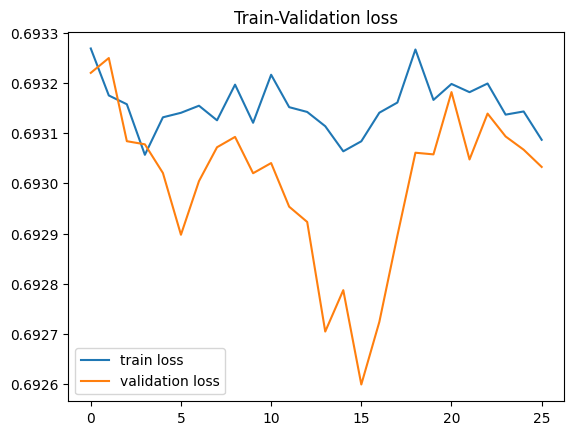

In [26]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_to_w2v_2'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [27]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.514030612244898, 'precision': 0.514030612244898, 'f1': 0.514030612244898, 'accuracy': 0.514030612244898}
MALE {'recall': 0.036458333333333336, 'precision': 0.036458333333333336, 'f1': 0.036458333333333336, 'accuracy': 0.036458333333333336}
FEMALE {'recall': 0.9725, 'precision': 0.9725, 'f1': 0.9725, 'accuracy': 0.9725} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.47474747474747475, 'precision': 0.47474747474747475, 'f1': 0.47474747474747475, 'accuracy': 0.47474747474747475}
MALE {'recall': 0.029197080291970802, 'precision': 0.029197080291970802, 'f1': 0.029197080291970802, 'accuracy': 0.029197080291970802}
FEMALE {'recall': 0.9553805774278216, 'precision': 0.9553805774278216, 'f1': 0.9553805774278216, 'accuracy': 0.9553805774278216} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4745762711864407, 'precision': 0.4745762711864407, 'f1': 0.4745762711864407, 'accuracy': 0.4745762711864407}


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6932006452349421 	 Validation loss: 0.6928137571124707 	 
  1%|          | 574/57400 [00:06<09:25, 100.55it/s]
Epoch 2 	 Training loss: 0.6931420374622743 	 Validation loss: 0.6927426477610055 	 
  2%|▏         | 1148/57400 [00:12<09:24, 99.60it/s]
Epoch 3 	 Training loss: 0.6931682587292967 	 Validation loss: 0.692897384449587 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:18<09:21, 99.24it/s]
Epoch 4 	 Training loss: 0.6931924876020346 	 Validation loss: 0.6928127903049275 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [00:24<09:07, 100.57it/s]
Epoch 5 	 Training loss: 0.6932242856416138 	 Validation loss: 0.6929701213109292 	 

3 epoch without improvement
  5%|▌         | 2870/57400 [00:31<09:11, 98.91it/s]
Epoch 6 	 Training loss: 0.6931632691767158 	 Validation loss: 0.692927094839387 	 

4 epoch without improvement
  6%|▌         | 3444/57400 [00:37<09:19, 96.49it/s]
Epoch 7 	 Training loss: 0.6931845031756557 	 Validation 

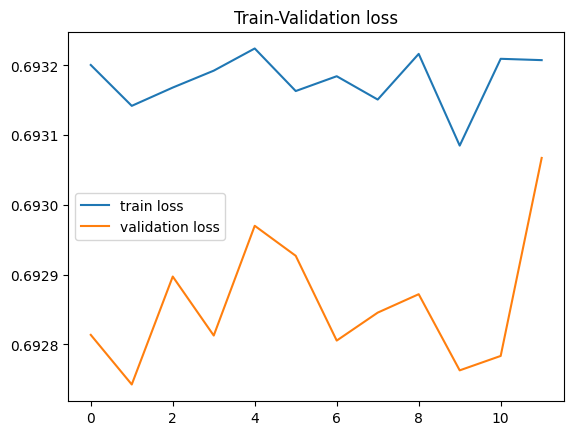

In [28]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_to_w2v_3'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [29]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.47831632653061223, 'precision': 0.47831632653061223, 'f1': 0.47831632653061223, 'accuracy': 0.47831632653061223}
MALE {'recall': 0.1640625, 'precision': 0.1640625, 'f1': 0.1640625, 'accuracy': 0.1640625}
FEMALE {'recall': 0.78, 'precision': 0.78, 'f1': 0.78, 'accuracy': 0.78} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4810606060606061, 'precision': 0.4810606060606061, 'f1': 0.4810606060606061, 'accuracy': 0.4810606060606061}
MALE {'recall': 0.1630170316301703, 'precision': 0.1630170316301703, 'f1': 0.1630170316301703, 'accuracy': 0.1630170316301703}
FEMALE {'recall': 0.8241469816272966, 'precision': 0.8241469816272966, 'f1': 0.8241469816272966, 'accuracy': 0.8241469816272966} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5097783572359843, 'precision': 0.5097783572359843, 'f1': 0.5097783572359843, 'accuracy': 0.5097783572359843}
MALE {'recall': 0.1717171717171717, 'precision': 0.17171

In [30]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.5008503401360545, 'precision': 0.5008503401360545, 'f1': 0.5008503401360545, 'accuracy': 0.5008503401360545}
Métricas etiqueta male: {'recall': 0.06684027777777778, 'precision': 0.06684027777777778, 'f1': 0.06684027777777778, 'accuracy': 0.06684027777777778}
Métricas etiqueta female:  {'recall': 0.9175, 'precision': 0.9175, 'f1': 0.9175, 'accuracy': 0.9175}

 to
Resultado global: {'recall': 0.47895622895622897, 'precision': 0.47895622895622897, 'f1': 0.47895622895622897, 'accuracy': 0.47895622895622897}
Métricas etiqueta male: {'recall': 0.0640713706407137, 'precision': 0.0640713706407137, 'f1': 0.0640713706407137, 'accuracy': 0.0640713706407137}
Métricas etiqueta female:  {'recall': 0.9265091863517061, 'precision': 0.9265091863517061, 'f1': 0.9265091863517061, 'accuracy': 0.9265091863517061}

 as
Resultado global: {'recall': 0.48935245545415035, 'precision': 0.48935245545415035, 'f1': 0.48935245545415035, 'accuracy': 0.489352

# AS

In [31]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6940503814079205 	 Validation loss: 0.6949230806302216 	 
  1%|          | 574/57400 [00:06<09:28, 99.94it/s]
Epoch 2 	 Training loss: 0.6933729488675188 	 Validation loss: 0.6940137915692087 	 
  2%|▏         | 1148/57400 [00:12<09:21, 100.19it/s]
Epoch 3 	 Training loss: 0.6932017437672365 	 Validation loss: 0.6934444924532357 	 
  3%|▎         | 1722/57400 [00:18<09:09, 101.42it/s]
Epoch 4 	 Training loss: 0.6932253062932748 	 Validation loss: 0.6931865286018889 	 
  4%|▍         | 2296/57400 [00:24<09:06, 100.91it/s]
Epoch 5 	 Training loss: 0.6931598637162185 	 Validation loss: 0.6928352370100507 	 
  5%|▌         | 2870/57400 [00:31<09:07, 99.58it/s]
Epoch 6 	 Training loss: 0.693144170041699 	 Validation loss: 0.6929740400637611 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [00:37<08:58, 100.28it/s]
Epoch 7 	 Training loss: 0.6932398340427917 	 Validation loss: 0.6931134361331746 	 

2 epoch without improvement
  7%|▋         | 4018/57400

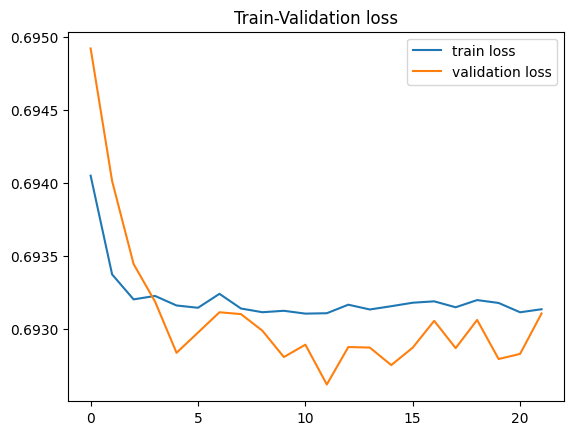

In [32]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_as_w2v_1'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [33]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.49362244897959184, 'precision': 0.49362244897959184, 'f1': 0.49362244897959184, 'accuracy': 0.49362244897959184}
MALE {'recall': 0.044270833333333336, 'precision': 0.044270833333333336, 'f1': 0.044270833333333336, 'accuracy': 0.044270833333333336}
FEMALE {'recall': 0.925, 'precision': 0.925, 'f1': 0.925, 'accuracy': 0.925} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4911616161616162, 'precision': 0.4911616161616162, 'f1': 0.4911616161616162, 'accuracy': 0.4911616161616162}
MALE {'recall': 0.09002433090024331, 'precision': 0.09002433090024331, 'f1': 0.09002433090024331, 'accuracy': 0.09002433090024331}
FEMALE {'recall': 0.9238845144356955, 'precision': 0.9238845144356955, 'f1': 0.9238845144356955, 'accuracy': 0.9238845144356955} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.49022164276401564, 'precision': 0.49022164276401564, 'f1': 0.49022164276401564, 'accuracy': 0.49022164276401564}


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6943234499115561 	 Validation loss: 0.6946841074248492 	 
  1%|          | 574/57400 [00:06<09:19, 101.54it/s]
Epoch 2 	 Training loss: 0.6933419333725441 	 Validation loss: 0.6939103674080412 	 
  2%|▏         | 1148/57400 [00:12<09:32, 98.34it/s]
Epoch 3 	 Training loss: 0.6932505950695131 	 Validation loss: 0.6932798785678411 	 
  3%|▎         | 1722/57400 [00:18<09:32, 97.23it/s]
Epoch 4 	 Training loss: 0.6932003524037603 	 Validation loss: 0.6932604777610908 	 
  4%|▍         | 2296/57400 [00:25<09:11, 99.90it/s]
Epoch 5 	 Training loss: 0.6931985266740314 	 Validation loss: 0.6931184035236553 	 
  5%|▌         | 2870/57400 [00:31<09:13, 98.57it/s]
Epoch 6 	 Training loss: 0.6932599680556653 	 Validation loss: 0.6930719119007305 	 
  6%|▌         | 3444/57400 [00:37<08:57, 100.37it/s]
Epoch 7 	 Training loss: 0.6932362355421644 	 Validation loss: 0.6929353425058268 	 
  7%|▋         | 4018/57400 [00:43<09:05, 97.81it/s]
Epoch 8 	 Training loss: 0.693156

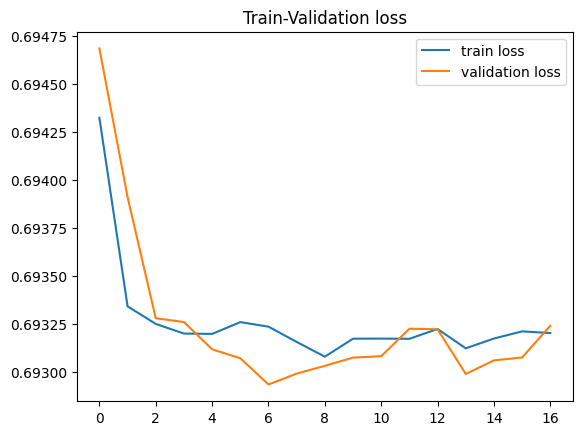

In [34]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_as_w2v_2'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [35]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.49107142857142855, 'precision': 0.49107142857142855, 'f1': 0.49107142857142855, 'accuracy': 0.49107142857142855}
MALE {'recall': 0.11979166666666667, 'precision': 0.11979166666666667, 'f1': 0.11979166666666667, 'accuracy': 0.11979166666666667}
FEMALE {'recall': 0.8475, 'precision': 0.8475, 'f1': 0.8475, 'accuracy': 0.8475} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4898989898989899, 'precision': 0.4898989898989899, 'f1': 0.4898989898989899, 'accuracy': 0.4898989898989899}
MALE {'recall': 0.1192214111922141, 'precision': 0.1192214111922141, 'f1': 0.1192214111922141, 'accuracy': 0.1192214111922141}
FEMALE {'recall': 0.889763779527559, 'precision': 0.889763779527559, 'f1': 0.889763779527559, 'accuracy': 0.889763779527559} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4915254237288136, 'precision': 0.4915254237288136, 'f1': 0.4915254237288136, 'accuracy': 0.4915254237288136}
MALE {'recal

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6932431425159401 	 Validation loss: 0.6929569385819516 	 
  1%|          | 574/57400 [00:06<09:24, 100.60it/s]
Epoch 2 	 Training loss: 0.693199136842834 	 Validation loss: 0.6927601614240873 	 
  2%|▏         | 1148/57400 [00:13<09:15, 101.31it/s]
Epoch 3 	 Training loss: 0.6931601373368439 	 Validation loss: 0.6928735577454002 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:19<09:32, 97.21it/s]
Epoch 4 	 Training loss: 0.6931774404406132 	 Validation loss: 0.692951673168247 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [00:25<09:40, 94.86it/s]
Epoch 5 	 Training loss: 0.693206014845014 	 Validation loss: 0.6931016263315233 	 

3 epoch without improvement
  5%|▌         | 2870/57400 [00:31<09:10, 99.10it/s]
Epoch 6 	 Training loss: 0.6932004733783442 	 Validation loss: 0.6928499745110334 	 

4 epoch without improvement
  6%|▌         | 3444/57400 [00:37<09:04, 99.06it/s]
Epoch 7 	 Training loss: 0.6931777894496918 	 Validation l

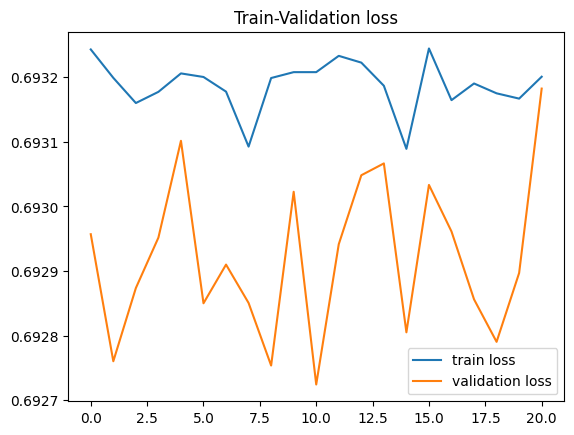

In [36]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_as_w2v_3'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [37]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.4961734693877551, 'precision': 0.4961734693877551, 'f1': 0.4961734693877551, 'accuracy': 0.4961734693877551}
MALE {'recall': 0.171875, 'precision': 0.171875, 'f1': 0.171875, 'accuracy': 0.171875}
FEMALE {'recall': 0.8075, 'precision': 0.8075, 'f1': 0.8075, 'accuracy': 0.8075} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.47095959595959597, 'precision': 0.47095959595959597, 'f1': 0.47095959595959597, 'accuracy': 0.47095959595959597}
MALE {'recall': 0.18491484184914841, 'precision': 0.18491484184914841, 'f1': 0.18491484184914841, 'accuracy': 0.18491484184914841}
FEMALE {'recall': 0.7795275590551181, 'precision': 0.7795275590551181, 'f1': 0.7795275590551181, 'accuracy': 0.7795275590551181} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.500651890482399, 'precision': 0.500651890482399, 'f1': 0.500651890482399, 'accuracy': 0.500651890482399}
MALE {'recall': 0.19696969696969696, 'precision': 0.

In [38]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.49362244897959184, 'precision': 0.49362244897959184, 'f1': 0.49362244897959184, 'accuracy': 0.49362244897959184}
Métricas etiqueta male: {'recall': 0.11197916666666667, 'precision': 0.11197916666666667, 'f1': 0.11197916666666667, 'accuracy': 0.11197916666666667}
Métricas etiqueta female:  {'recall': 0.86, 'precision': 0.86, 'f1': 0.86, 'accuracy': 0.86}

 to
Resultado global: {'recall': 0.484006734006734, 'precision': 0.484006734006734, 'f1': 0.484006734006734, 'accuracy': 0.484006734006734}
Métricas etiqueta male: {'recall': 0.13138686131386862, 'precision': 0.13138686131386862, 'f1': 0.13138686131386862, 'accuracy': 0.13138686131386862}
Métricas etiqueta female:  {'recall': 0.8643919510061242, 'precision': 0.8643919510061242, 'f1': 0.8643919510061242, 'accuracy': 0.8643919510061242}

 as
Resultado global: {'recall': 0.4941329856584094, 'precision': 0.4941329856584094, 'f1': 0.4941329856584094, 'accuracy': 0.4941329856584094}